## 问题核心：
求油流随管道流动其温度的变化情况，忽略径向温度变化，只考虑轴向温度变化，则核心是列宗宾公式
$$
T_{l} = T_{0}+b+[T_{R}-(T_{0}+b)]e^{-al} \\
a = \frac{K\pi D}{Gc} \\
b = \frac{gi}{ca}
$$
### 需要求解的量
- 比热容c
- 总传热系数K
- 水力坡降i

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### 基本参数计算：
#### 1. 常规参数设置
- t——初始温度为45摄氏度
- G——油品的质量流量 1200 万t/年
- e——钢管内部粗超度 0.05 mm
- g——重力加速度9.8 $m /s ^{2}$
- T0——管道周围介质温度20°C
- L——管道全长410.2km
- h_t——管道埋深1.6m
- T_R——加热站起点温度53°C
- T_Z——加热站终点温度35°C

In [2]:
t = 45
G = 1200 * 10** 7 / (350 * 24 * 3600)   #kg/s
e = 5 * 10 ** (-5)  
g = 9.8    
T0 = 20
L = 410200
h_t = 1.6
T_R = 53
T_Z = 35
G

396.8253968253968

2. 确定油品密度函数  
$$
\rho _{20} =857.5(kg/m^{3})、t=45°C\\
\varepsilon_{t}=1.825-1.315\times 10^{-3}\rho _{20} \\
\rho =\rho_{20}-\varepsilon _{t}(t-2)  \\
$$

$\rho$ ——计算一个温度值对应的原油密度，kg/m3;   
$\rho _{20}$ ——20°C时的油品密度，kg/m3;  
t——原油温度，°C;  
$\varepsilon _{t}$——温度系数，kg/(m3·°C)。


In [3]:
def rho(t):
    rho_20 =857.5
    varepsilon_t=1.825-1.315 * 10**-3 * rho_20
    rho = rho_20 - varepsilon_t * (t-2) 
    return rho
rho(t)

827.5123375

- 用油品密度确定油品质量Q函数
$$
Q = \dfrac{G}{\rho}
$$
Q——体积流量，m3/s;   
G——质量流量，kg/s;  
ρ——原油密度，kg/m3

In [4]:
def Q(t):
    Q = G/rho(t)
    return Q
Q(t)

0.4795401577023579

4.用质量流量求出管道参数  
经济流速范围1.5m/s～2m/s，取1.8m/s  
$$
Q = \frac{\pi }{4}d^{2}\upsilon 
$$
d——输油管道内径，m;   
v ——原油流速，m/s

In [5]:
upsilon = 1.8
d = np.sqrt(Q(t)/(np.pi/4)/upsilon)
d

0.5824133183359554

由《输油管道设计与管理》查到最接近的钢管尺寸：
- 外经 D = 610 mm
- 壁厚 h = 14.3 mm
- 内径 d = 582.4 mm
- 管重 210 kg/m

In [6]:
D=0.610
h=0.0143
d=0.5824

***
### 1. 比热容c计算函数
$$
c=4.186-0.9085e^{0.01732t}
$$

In [7]:
def c(t):
    c=1000*(4.186-0.9085 * np.e **(0.01732 * t))
    return c
c(t)

2205.3212106619844

***
### 2. 水力坡降i计算函数
要计算水力坡降i首先要先计算雷诺数判断流态
雷诺数计算公式：  
$$
Re = \dfrac{4Q}{\pi d\vartheta} \\
\varepsilon = \dfrac{2e}{d}\\
Re_{1} = \dfrac{59.5}{\varepsilon^{8/7}}\\
Re_{2} = \dfrac{665-765lg\varepsilon}{\varepsilon}
$$
Q——油品体积流量，m3/s  
d——管道内径，m;  
Re1、Re2——临界雷诺数;  
ν——油品运动粘度，m2/s;   
ε——管壁相对当量粗糙度;   
e——管壁绝对当量粗糙度。   

#### 其中有未知数：
- 运动粘度$\vartheta (m ^{2}/s)$——$\frac{\mu}{\rho}$
- 管壁相对粗糙度$\varepsilon$——$\frac{2e}{d}$ (需要估算管径)


#### 未知参数计算
- 运动粘度函数：
$$
\vartheta=\dfrac{8000\times e^{-0.2949t}}{\rho}
$$

In [8]:
def vartheta(t):
    vartheta=8000 * np.e ** (-0.2949 * t)/rho(t)
    return vartheta
vartheta(t)

1.667287858002476e-05

- 管壁相对粗糙度计算式
$\varepsilon = \dfrac{2e}{d}$

In [9]:
varepsilon = 2*e/d
varepsilon

0.0001717032967032967

#### 雷诺数计算
雷诺数计算公式：  
$$
Re = \dfrac{4Q}{\pi d\vartheta} \\
Re_{1} = \dfrac{59.5}{\varepsilon^{8/7}}\\
Re_{2} = \dfrac{665-765lg\varepsilon}{\varepsilon}
$$

In [10]:
def Re(t):
    Re = 4 * Q(t) / (np.pi*d*vartheta(t))
    return Re
Re1 = 59.5/varepsilon**(8/7)
Re2 = (665-765*np.log10(varepsilon))/varepsilon

Re(t),Re1,Re2

(62878.64099326381, 1195713.406523121, 20648376.66658056)

不同流态下Re的数值范围  

流态|划分范围|水力坡降i|水力摩阻系数$\lambda$
:-:|:-:|:-:|:----:
层流 | Re<2000 | $\dfrac{4.15Q\vartheta}{d^{4}}$ | $\lambda = \dfrac{64}{Re}$
过渡流 | 2000≤Re≤3000 | $0.0124Q^{1.75} \vartheta^{0.25}$ | $\frac{1}{\sqrt{\lambda}}=1.811gRe-1.53,\lambda = 0.3164Re^{-0.25}$
水力光滑区 | 3000<Re≤Re1 | $0.0246\dfrac{Q^{1.75}\vartheta^{0.25}}{d^{4.75}}$ | $\frac{1}{\sqrt{\lambda}}=-2lg\left ( \frac{e}{3.7d}+\frac{2.51}{Re\sqrt{\lambda}}\right ) , \lambda = 0.11(\frac{e}{d}+\frac{68}{Re})^{0.25}$
混合摩擦区 | Re1<Re≤Re2 | $0.0802A \dfrac{Q^{1.877}\vartheta^{0.123}}{d^{4.877}}$ | $\frac{1}{\sqrt{\lambda}}=-2lg\left ( \frac{e}{3.7d}+\frac{2.51}{Re\sqrt{\lambda}}\right ) , \lambda = 0.11(\frac{e}{d}+\frac{68}{Re})^{0.25}$
完全粗糙区 | Re>Re2 | $0.0826\lambda\dfrac{Q^{2}}{d^{5}}$ | $\lambda = \frac{1}{(1.74 - 2lg \epsilon )^{2}}$


由结果可以看出流态处于水力光滑区  
$$
i =0.0246\dfrac{Q^{1.75}\vartheta^{0.25}}{d^{4.75}}
$$

In [40]:

def num_i(t):
    if Re(t) < 2000:
        num_i = 4.15 * Q(t) * vartheta(t) / d ** 4
    if Re(t) >= 2000 and Re(t) <= 3000:
        num_i = 0.0124 * Q(t) ** 1.75 * vartheta(t) ** 0.25
    if Re(t) > 3000 and Re(t) <= Re1:
        num_i = 0.0246 * Q(t) ** 1.75 * vartheta(t) ** 0.25 / d ** 4.75
    if Re(t) > Re1 and Re(t) <= Re2:
        A = 10 ** (0.127 * np.log10(e/d) * 0.627 )
        num_i = 0.0802 * A * Q(t) ** 1.899 * vartheta(t) ** 0.123 / d ** 4.877
    if Re(t) > Re2:
        lambd = 0.11 * (e/d) ** 0.25
        num_i = 0.0826 * lambd * Q(t) ** 2 / d ** 5
    return num_i
num_i(t)

0.0056634358043659815

***
### 3. 总传热系数K计算
$$
K = \frac{1}{\frac{1}{\alpha _{1}}+\frac{1}{\alpha _{2}}+\frac{\delta _{1}}{\lambda _{1}}+\frac{\delta _{2}}{\lambda _{2}}}
$$
- $\alpha _{1}$——油流到管内壁放热系数（通过雷诺系数确定计算式，若紊流状态下$\alpha _{1}$要比层流时大得多，通常情况下二者 可能相差数十倍。因此，紊流时的$\alpha _{1}$对总传热系数的影响很小，可以忽略）
- $\alpha _{2}$——管壁至土壤的放热系数（$\lambda _{t}$ =1.4 W/m·°C）   
$\alpha _{2} = \frac{2\lambda _{t}}{Dln\left [\frac{2h_{t}}{D} +\sqrt{(\frac{2h_{t}}{D})^{2}-1}\right ]}$
    - $h _{t}$为管埋深度1.6m
- $\alpha _{3}$——钢的放热系数：$\lambda _{1} = 48 W/m·°C, \delta _{1}=h=0.0143m$
- $\alpha _{4}$——沥青的放热系数：$\lambda _{2} = 0.15 W/m·°C,  \delta _{2} = 8 \times 10^{-5}m$


In [42]:
lambda_t =1.4
alpha2 = 2 * lambda_t/(D * np.log(2*h_t/D + np.sqrt((2*h_t/D)**2 - 1)))
delta1= h
delta2= 0.00008
lambda_1 = 48
lambda_2 = 0.15
K = 1/(1/alpha2+ delta1/lambda_1 + delta2/lambda_2)
1/alpha2, delta1/lambda_1, delta2/lambda_2


(0.5100871169835972, 0.00029791666666666665, 0.0005333333333333334)

***
### 需要求解的量已经求解完毕，下面来计算T关于l的函数
- 比热容c
- 总传热系数K
- 水力坡降i
$$
T_{l} = T_{0}+b+[T_{R}-(T_{0}+b)]e^{-al} \\
a = \frac{K\pi D}{Gc} \\
b = \frac{gi}{ca}
$$

In [43]:
def a(t):
    a = K*np.pi*D / (G * c(t)) 
    return a
a(t)

4.286046501155319e-06

In [45]:
def b(t):
    b = g * num_i(t) / (c(t) * a(t))
    return b
b(t)

5.871882070198885


#### 在计算温度之前需要先确定布置加热站，来得到两站之间的距离l的函数
石油凝点为30°C，进入加热站的温度要高于凝点温度3～5°C，在此设为35°C  
加热站数——$n _{R} = \frac {L}{l _{R}}$   
加热间距——$l _{R} = \frac{Gc}{K\pi D}ln\frac {T_{R}-T_{0}-b}{T_{z}-T_{0}-b}$

In [46]:
def l_R(t):
    l_R = G *c(t)/(K*np.pi*D) *np.log((T_R - T0-b(t))/(T_Z-T0-b(t)))
    return l_R
l_R(t)

254129.58530415467

In [47]:
def n_R(t):
    n_R =np.ceil(L/l_R(t))
    return n_R
n_R(t)

2.0

In [51]:
def l(t):
    l = L/(n_R(t)+1)
    return l
l(t)

136733.33333333334

In [52]:
l = l(t)
num_b = b(t)
def T_l(t, l):
    T_l = T0 + num_b + (t - (T0 + num_b))*np.e**(-a(t)*l)
    return T_l
T_l(t, l),c(t), num_i(t)

(36.51713406336666, 2205.3212106619844, 0.0056634358043659815)

In [53]:
n = 0
k = 0
tem = []
while True:
    n += 1000
    tem.append(T_l(53, n))
    if n > l:
        k +=1
        n = 0
    if k == 3:
        break

len(tem)

411

411

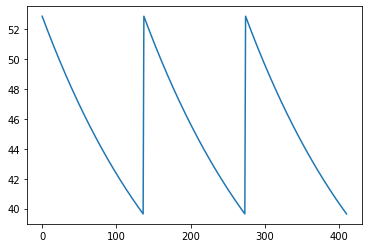

In [54]:
x = np.arange(0, L, 1000)
y = tem
plt.plot(x/1000, y, label ='linear')
len(x)

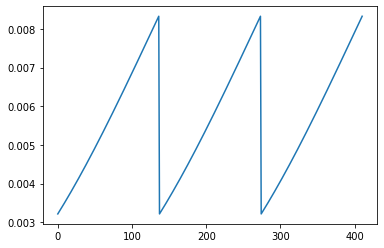

In [55]:
num_i1 = []
x = np.arange(0, L, 1000)
for j in range(len(tem)):
    num_i1.append(num_i(tem[j]))
plt.plot(x/1000, num_i1, label ='linear')

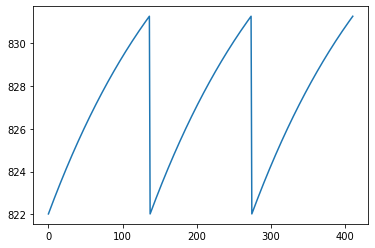

In [56]:
num_rho = []
x = np.arange(0, L, 1000)
for j in range(len(tem)):
    num_rho.append(rho(tem[j]))
plt.plot(x/1000, num_rho, label ='linear')

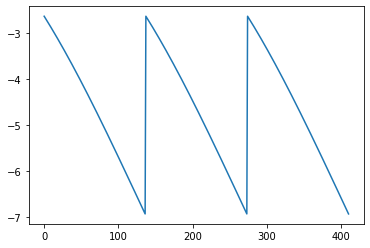

In [58]:
multi_i_rho = []
x = np.arange(0, L, 1000)
for j in range(len(tem)):
    multi_i_rho.append(-rho(tem[j]) * num_i(tem[j]))
plt.plot(x/1000, multi_i_rho, label ='linear')

***
## 前面加热站计算完毕下面计算泵站
### 压力计算公式
$$
压力P=长度/高度 \times 密度\rho \times g
$$
### 泵站要求：
- 泵站入口最低压力P_min = 0.5MPa  
- 泵站出口最高压力P_max = 6MPa    
### 首先计算流量，选用泵

In [59]:
P_min = 0.5 * 10 ** 6
P_max = 6 * 10 ** 6
def h_max(t):
    h_max = P_max / rho(t)/g
    return h_max
h_max(t)

739.8619575979236

In [60]:
def Q_h(t):    # 计算每小时的流量，用于选用泵
    Q_h = Q(t) * 3600
    return Q_h
Q_h(t)

1726.3445677284885

### HSB14-14-14-16.5I型号泵扬程-流程曲线拟合
#### 数据集：  
x =[35.48774,139.62958,283.44449,432.21854,580.99259,744.64404,928.13204,1176.08879,1424.04553,1672.00228,1964.59124,2321.64896,2653.911,2966.33651,3219.25239]   
y =  
[252.16587,251.96386,251.55983,252.16587,252.16587,252.36788,252.16587,251.96386,250.75178,250.14575,246.91355,239.03506,229.94451,219.84389,208.7332]


x is :
 [  35.48774  139.62958  283.44449  432.21854  580.99259  744.64404
  928.13204 1176.08879 1424.04553 1672.00228 1964.59124 2321.64896
 2653.911   2966.33651 3219.25239]
y is :
 [252.16587 251.96386 251.55983 252.16587 252.16587 252.36788 252.16587
 251.96386 250.75178 250.14575 246.91355 239.03506 229.94451 219.84389
 208.7332 ]
15
15
f1 is :
 [-2.14445020e-09  2.73686013e-06 -7.18083170e-05  2.51826825e+02]
p1 is :
             3             2
-2.144e-09 x + 2.737e-06 x - 7.181e-05 x + 251.8
yvals is :
 [251.82762794 251.86431997 251.97751941 252.1339177  252.28837914
 252.4054822  252.40325798 252.03947536 251.08185358 249.33423954
 245.98853747 239.57668644 230.82825817 219.72304314 208.41405197]


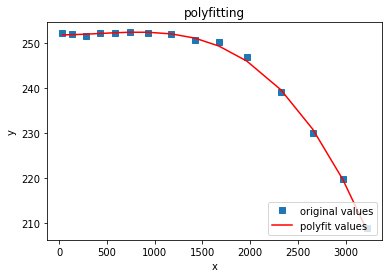

In [61]:
#定义x、y散点坐标
x = [35.48774,139.62958,283.44449,432.21854,580.99259,744.64404,928.13204,1176.08879,1424.04553,1672.00228,1964.59124,2321.64896,2653.911,2966.33651,3219.25239]
x = np.array(x)
print('x is :\n',x)
num = [ 252.16587,251.96386,251.55983,252.16587,252.16587,252.36788,252.16587,251.96386,250.75178,250.14575,246.91355,239.03506,229.94451,219.84389,208.7332]
y = np.array(num)
print('y is :\n',y)
print(len(x))
print(len(num))
#用3次多项式拟合
f1 = np.polyfit(x, y, 3)
print('f1 is :\n',f1)

p1 = np.poly1d(f1)
print('p1 is :\n',p1)
yvals = p1(x)  #拟合y值
print('yvals is :\n',yvals)

#绘图
plot1 = plt.plot(x, y, 's',label='original values')
plot2 = plt.plot(x, yvals, 'r',label='polyfit values')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc=4) #指定legend的位置右下角
plt.title('polyfitting')
plt.show()

#### 由结果可以得到HSB14-14-14-16.5I型号扬程-流程的拟合方程

In [62]:
def H1_Q(Q):
    H1 = -2.144* 10 **(-9) * Q ** 3 + 2.737 * 10 ** (-6) * Q ** 2 - 7.181 * 10 ** (-5) * Q + 251.8
    return H1
H1_Q(Q(t))

251.799966193382


### ZMIPII型号泵扬程-流程曲线拟合
#### 数据集：  
x =[30.87812,140.98369,331.16603,431.262,706.52591,836.65067,951.76104,1262.05854,1497.28407,1722.5,1922.69194,2132.89347,2308.06142,2483.22937,2668.40691,2823.55566,3013.738]   
y =  
[138.19001,138.01303,137.83606,137.77707,137.24615,137.01018,136.77422,136.00734,135.06348,134.35559,133.5887,132.40888,130.93411,129.6363,127.80758,125.97886,124.09114]


x is :
 [  30.87812  140.98369  331.16603  431.262    706.52591  836.65067
  951.76104 1262.05854 1497.28407 1722.5     1922.69194 2132.89347
 2308.06142 2483.22937 2668.40691 2823.55566 3013.738  ]
y is :
 [138.19001 138.01303 137.83606 137.77707 137.24615 137.01018 136.77422
 136.00734 135.06348 134.35559 133.5887  132.40888 130.93411 129.6363
 127.80758 125.97886 124.09114]
17
17
f1 is :
 [-5.24295240e-10  5.42267095e-07 -1.62673595e-03  1.38288506e+02]
p1 is :
             3             2
-5.243e-10 x + 5.423e-07 x - 0.001627 x + 138.3
yvals is :
 [138.23877701 138.06847184 137.79021518 137.6457579  137.22495322
 137.0000252  136.77943209 136.04525209 135.30860464 134.41586409
 133.43888312 132.19849783 130.97622514 129.56444619 127.84720016
 126.21627825 123.95981605]


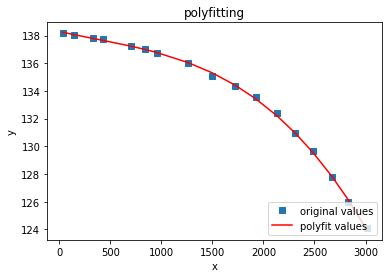

In [63]:

#定义x、y散点坐标
x = [30.87812,140.98369,331.16603,431.262,706.52591,836.65067,951.76104,1262.05854,1497.28407,1722.5,1922.69194,2132.89347,2308.06142,2483.22937,2668.40691,2823.55566,3013.738]
x = np.array(x)
print('x is :\n',x)
num = [138.19001,138.01303,137.83606,137.77707,137.24615,137.01018,136.77422,136.00734,135.06348,134.35559,133.5887,132.40888,130.93411,129.6363,127.80758,125.97886,124.09114]
y = np.array(num)
print('y is :\n',y)
print(len(x))
print(len(num))
#用3次多项式拟合
f1 = np.polyfit(x, y, 3)
print('f1 is :\n',f1)

p1 = np.poly1d(f1)
print('p1 is :\n',p1)
yvals = p1(x)  #拟合y值
print('yvals is :\n',yvals)

#绘图
plot1 = plt.plot(x, y, 's',label='original values')
plot2 = plt.plot(x, yvals, 'r',label='polyfit values')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc=4) #指定legend的位置右下角
plt.title('polyfitting')
plt.show()


#### 由结果可以得到ZMIPII型号扬程-流程的拟合方程

In [64]:
def H2_Q(Q):
    H2 = -5.243 * 10 **(-10) * Q ** 3 +5.423 * 10 ** (-7) * Q ** 2 - 0.001627 * Q + 138.3
    return H2
H2_Q(Q(t))

138.29921991281225

#### 组合泵选择
- HSB14-14-14-16.5I型号泵在流量为1726$m ^{3}/h$时扬程约为252m
- ZMIPII型号泵在流量为1726$m ^{3}/h$时扬程约为138m   
综上，由于6MPa对应扬程约为740m，故采用2台HSB14-14-14-16.5I型号泵与一台ZMIPII型号泵串联扬程为640m以接近740m扬程


In [94]:
H_sum =  H1_Q(Q(t)) + 2 * H2_Q(Q(t))
def P_beng(t):
    P_beng =  H_sum*rho(t)*g
    return P_beng
P0 = H_sum*rho(t)*g + 500000
H_sum,P0,P_beng(t)

(641.8991522995763, 5705558.7859951705, 5205558.7859951705)

### 泵站个数确定

In [66]:
h_sz = 500000 / (rho(t) * g)
n_beng = (num_i(t) * L + h_sz)/ H_sum
n_beng

3.7152199399869192

In [67]:
beng_l = L / 5
beng_l

82040.0

In [68]:
def change_H(x):
    if x < 7.72319:
        y = 9.36544355 * x + 60
    if 7.72319 <= x < 32.39916:
        y = -4.81951267 * x + 169.553112
    if 32.39916 <= x < 46.01348:
        y = 6.50696105 * x - 197.415122
    if 46.01348 <= x < 114.936:
        y = 1.13566654 * x + 49.73683302
    if 114.936 <= x < 220.447:
        y = -0.879862574 * x + 281.393485
    if 220.447 <= x < 391.0515:
        y = -0.058683388 * x + 100.366997
    if x>=391.0515:
        y = -0.209731817 * x +159.434712
    return y
change_H(20)

73.16285859999999

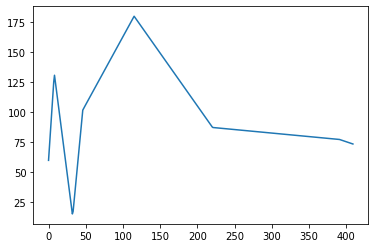

In [69]:
x = np.arange(0, 410, 1)
num_y = []
for i in range(len(x)):
    y = change_H(x[i])
    num_y.append(y)

plt.plot(x, num_y, label ='linear')

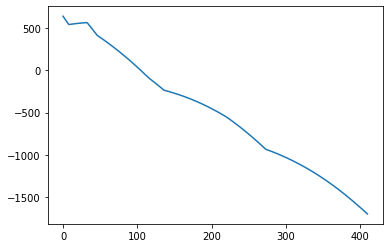

In [103]:
H_sum =  H1_Q(Q(t)) + 2 * H2_Q(Q(t))
sum_H = H_sum
array_i = []
for j in range(len(tem)):
    x = j * 1000
    if j == 0:
        num_j = sum_H-num_i(tem[j])*1000
    else:
        num_j = sum_H-num_i(tem[j])*1000 - (change_H(j)-change_H(j-1))
    sum_H = num_j
    array_i.append(num_j)
num_x = np.arange(0,  L , 1000)
plt.plot(num_x/1000, array_i, label ='linear')


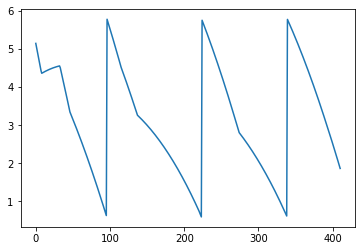

In [104]:
array_p = []
for i in range(len(array_i)):
    if i < 96:
        number_i = (array_i[i] * 9.8 * rho(tem[i]))/1000000
    if i>= 96 and i<224:
        number_i = (array_i[i] * 9.8 * rho(tem[i]) + P_beng(tem[i]))/1000000
    if i>=224 and i<339:
        number_i = (array_i[i] * 9.8 * rho(tem[i]) + 2*P_beng(tem[i]))/1000000
    if i>=339:
        number_i = (array_i[i] * 9.8 * rho(tem[i]) + 3*P_beng(tem[i]))/1000000
    array_p.append(number_i)
    if number_i < 0.5:
        print(i)
num_x = np.arange(0,  L , 1000)
plt.plot(num_x/1000, array_p, label ='linear')

In [ ]:
array_p = []
for i in range(len(array_i)):
    if i<83:
        number_i = (array_i[i] * 9.8 * rho(tem[i]))/1000000
    if i>=83 and i<176:
        number_i = (array_i[i] * 9.8 * rho(tem[i]) + P_beng(tem[i]))/1000000
    if i>=176 and i<267:
        number_i = (array_i[i] * 9.8 * rho(tem[i]) + 2*P_beng(tem[i]))/1000000
    if i>=267 and i<372:
        number_i = (array_i[i] * 9.8 * rho(tem[i]) + 3*P_beng(tem[i]))/1000000
    if i>=372:
        number_i = (array_i[i] * 9.8 * rho(tem[i]) + 4*P_beng(tem[i]))/1000000
    array_p.append(number_i)
    if number_i < 0.5:
        print(i)
num_x = np.arange(0,  L , 1000)
plt.plot(num_x/1000, array_p, label ='linear')